## Second workflow: rainfall runoff model ##

Our second workflow will use a simple custom made weather generator and hydrological model in order to explore more advanced functionnalities of [snakemake](https://snakemake.readthedocs.io/en/stable/):

- generalization of rules with wildcards (eg application for several datasets/model instance)
- parameter exploration with paramspace (eg model calibration)
- automatic parallelisation

We use notebooks to interactively create files on the fly (%%writefile): Snakefile_RR, config/snake_config_RR.yml, hydro_parameters.csv.

And to run snake command lines on the fly: cells starting with **!**

Let's dive into it!

### Import necessary python libraries and switch to the right repository ###

To properly run our jupyter notebook we need to import the following libraries:

In [1]:
# Import some python python libraries we will need to run this notebook
import os
from IPython import display

The workflow will take longer to run so we will use a custom CLI interface called **runrealcmd** instead of **!** to print Snake log on the fly.

In [3]:
# A helper function (to get command line response in real time)
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

**And we should make sure that we are running from the right folder!**

Use the following lines to move to the folder deltares_snakemake:

In [4]:
#Should point to the folder where deltares_snakemake is stored
print(os.getcwd())
# Else uncomment to move to proper directory
os.chdir('..')
print(os.getcwd())
# Or directly enter the path here
#os.chdir(r'd:/repos/deltares_snakemake')
#print(os.getcwd())

c:\Code\Snakemake\deltares_snakemake\notebooks
c:\Code\Snakemake\deltares_snakemake


### Rainfall runoff workflow ###

#### Explore the workflow ####

In the rainfall-runoff workflow, we have **two rules** that produces climate timeseries using a **weather generator** and then run a **hydrological model** to produce river flow timeseries from the generated climate.

The different options like the output folder or the parameters of each model are defined in a config file located in **config/snake_config.yml**.

The different elements of the *weather generator* rule are:
  - No input file, we will start as we will generate weather from scratch.
  - The weather geneator is a python script located in **scripts/weather_generator.py**
  - The output file contains precipitation `p` and evaporation `ep` timeseries that will be saved in **data/precip_evapo.csv**
  - The parameters of the weather generator file are: `start_date`, `end_date`, `multiplier`, `evapo`, `p_01` and `p_10`, `rainfall_thres`, representing start and end date, a multiplier to compute rainfall from a randomly drawn number between zero and one, a constant evaporation rate, and markov probabilities of transitions from dry to wet and wet to dry day, and a rainfall threshold (in mm per day) to define if a day is wet or dry.

The different elements of the *hydrological model* rule are:
  - Precipitation timeseries come from a file located in **data/precip_evapo.csv**
  - The hydrological model is here a python script located in **scripts/simple_hydrology.py**
  - The output file of the hydrological model will be a discharge timeseries saved in **output/river_flow.csv**
  - The parameters of the hydrological model are a dictionnary hydro_prameters containing the varibales: interception, storage_1_max, alpha, k_fast, k_slow, storage_1, storage_2

Have a look at what the Snakefile of our workflow looks like and try to identify the different elements from the list above in the worflow:

In [13]:
%%writefile ./Snakefile_RR
# This first line is used to save the snake code below into a file called "Snakefile"

######################################################################################
####################### Content of the Snakefile #####################################
### Import some useful python library ###

### Worflow and rules ###
# The master rule defines what eventually will be expected as output, basically it is a rule with only inputs
rule all:
    input:
        hydro_csv = config["output_dir"] + "river_flow.csv"
    	

# rule to generate weather timeseries
rule weather_generator:
    # there is not input section because this rule does not require any inputs
    output:
        weather_csv = "data//precip_evapo.csv"
    # parameters can be anything like strings, numbers, etc.
    params:
    	start_date = config["start_date"],
    	end_date = config["end_date"],
    	multiplier = config["multiplier"],
    	evapo = config["evapo"],
    	p_01 = config["p_01"],
    	p_10 = config["p_10"],
    	rainfall_thres = config["rainfall_thres"]
    script:
        "scripts//weather_generator.py"

# Rule to run the hydrology model with input from the weather generator
rule run_simple_model:
    input:
        weather_csv = "data//precip_evapo.csv"
    output:
        hydro_csv = config["output_dir"] + "river_flow.csv"
    params:
        hydro_parameters = config["hydro_parameters"]
    script:
        "scripts//simple_hydrology.py"

Overwriting ./Snakefile_RR


A first version of the config file has already been prepared in config/snake_config.yml. Let's see its content and identify the different parameters of our models and their initial values:

In [14]:
with open("config/snake_config.yml", "r", encoding="utf8") as f:
    txt = f.read()
print(txt)

# Here general configuration things are stored, which can be used as inputs to workflow rules
# within the snakemake workflow. The layout is standard yaml and will be available in snakemake
# as a dictionary

# a relative path to output
output_dir: output/

## Weather generator parameters ##
# some other parameters for generating random meteorological forcing with a very simple model
start_date: 2022-09-01
end_date: 2022-12-31
# we use constant evaporation in this simple model
evapo: 1.5
# transition probability of dry to wet day is 20% Change to try out other values
p_01: 0.2
# transition probability of wet to dry day is 30%
p_10: 0.3
# random numbers are multiplied by this number to ensure we get a certain amount reasonable for mm per day 
multiplier: 50
# when rainfall is lower than 1.0 mm per day, it is considered a dry day
rainfall_thres: 1.0
## Hydrology model parameters ##
hydro_parameters:
  # below we define some parameters for a very simple hydrological model, stocks in mm an

First, you can create an image of the content of the snakefile and the different workflows using the following command:

Building DAG of jobs...


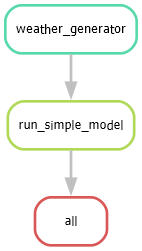

In [15]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

We see out two rules to run the **weather_generator** followed by the hydrological model run **run_simple_model** and the final rule **all** to let snakemake know when our workflow is finished. And now let's run our workflow to see if it all works well:

In [17]:
! snakemake --unlock -s Snakefile_RR --configfile config/snake_config.yml
%runrealcmd snakemake all -s Snakefile_RR -c 1 --configfile config/snake_config.yml

Building DAG of jobs...
Unlocked working directory.


Assuming unrestricted shared filesystem usage.
host: L50060
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                  count
-----------------  -------
all                      1
run_simple_model         1
weather_generator        1
total                    3

Select jobs to execute...
Execute 1 jobs...

[Mon Nov 25 15:04:39 2024]
localrule weather_generator:
    output: data//precip_evapo.csv
    jobid: 2
    reason: Missing output files: data//precip_evapo.csv
    resources: tmpdir=C:\Users\vertegaa\AppData\Local\Temp

Creating weather data from 2022-09-01 to 2022-12-31
Writing weather data to c:\Code\Snakemake\deltares_snakemake\data\precip_evapo.csv
Plotting weather data in c:\Code\Snakemake\deltares_snakemake\data\weather_plot.jpg
[Mon Nov 25 15:04:41 2024]
Finished job 2.
1 of 3 steps (33%) done
Select jobs to execute...
Execute 1 jobs...

[Mon Nov 25 15:04:41 2024]
localrule run_s

Normally you should now see that a precip_evapo.csv file has been created in your data folder, as well as the corresponding river_flow.csv in the output folder. An additinal plot of the generated weather is also available in data/weather_plot.jpg. Let's have a look at it:

In [18]:
display.Image("./data/weather_plot.jpg")

FileNotFoundError: No such file or directory: './data/weather_plot.jpg'

FileNotFoundError: No such file or directory: './data/weather_plot.jpg'

<IPython.core.display.Image object>

#### Using wildcards ####

**Wildcards** are useful to generalize and automatically repeat rules, for example running several hydrological models for different basins or several instances of the weather generator.
In our example, we will see how to use wildcards to run our weather generator workflow several times.

We will introduce a wildcard called **weagen** and define its instances in our config file (we will create a copy called config/snake_config_RR.yml).

For more info on wildcards see the snakemake [documentation](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#wildcards).

But first see what our snakefile will look like:

- **{}** are used when calling the wildcard: `{weagen}` --> they are parsed automatically by Snake.
- the name of our file contains the **wildcard pattern** to track the different outputs of each run of the weather generator (one output file per run with a different name)
- the wildcard content (IDs of each weagen run) is defined at the end in the rule `all` when gathering all the results with the function **expand**

In [19]:
%%writefile ./Snakefile_RR
# This first line is used to save the snake code below into a file called "Snakefile"

######################################################################################
####################### Content of the Snakefile #####################################
### Import some useful python library ###

### Worflow and rules ###
# The master rule defines what eventually will be expected as output, basically it is a rule with only inputs
rule all:
    input:
        expand((config["output_dir"] + "river_flow_{weagen}.csv"), weagen=config["weagen_ids"])
    	

# rule to generate weather timeseries
rule weather_generator:
    # there is not input section because this rule does not require any inputs
    output:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    # parameters can be anything like strings, numbers, etc.
    params:
    	start_date = config["start_date"],
    	end_date = config["end_date"],
    	multiplier = config["multiplier"],
    	evapo = config["evapo"],
    	p_01 = config["p_01"],
    	p_10 = config["p_10"],
    	rainfall_thres = config["rainfall_thres"]
    script:
        "scripts/weather_generator.py"

# Rule to run the hydrology model with input from the weather generator
rule run_simple_model:
    input:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    output:
        hydro_csv = config["output_dir"] + "river_flow_{weagen}.csv"
    params:
        hydro_parameters = config["hydro_parameters"]
    script:
        "scripts/simple_hydrology.py"

Overwriting ./Snakefile_RR


Let's now define our {weagen} instances (keyword used to track the run) in a new config file using the keyword **weagen_ids**. For xample we can call our two runs "weagen1" and "weagen2"

In [20]:
%%writefile ./config/snake_config_RR.yml
# This first line is used to save the snakeconfig below into a file called "config/snake_config_RR.yml"

######################################################################################
####################### Content of the snake config ##################################
# Here general configuration things are stored, which can be used as inputs to workflow rules
# within the snakemake workflow. The layout is standard yaml and will be available in snakemake
# as a dictionary

# a relative path to output
output_dir: output/

## Weather generator parameters ##
# Defining the different weathergen run instances
weagen_ids: ["weagen1","weagen2"]
# some other parameters for generating random meteorological forcing with a very simple model
start_date: 2022-09-01
end_date: 2022-12-31
# we use constant evaporation in this simple model
evapo: 1.5
# transition probability of dry to wet day is 20% Change to try out other values
p_01: 0.2
# transition probability of wet to dry day is 30%
p_10: 0.3
# random numbers are multiplied by this number to ensure we get a certain amount reasonable for mm per day 
multiplier: 50
# when rainfall is lower than 1.0 mm per day, it is considered a dry day
rainfall_thres: 1.0

## Hydrology model parameters ##
hydro_parameters:
  # below we define some parameters for a very simple hydrological model, stocks in mm and time scales in days
  interception: 1
  storage_1_max: 100
  alpha: 0.6
  k_fast: 7
  k_slow: 150
  storage_1: 40
  storage_2: 20

Overwriting ./config/snake_config_RR.yml


Let's produce a new image of our workflow and see how Snake understood our wildcard and the two instances of the weathergenerator run:

Building DAG of jobs...


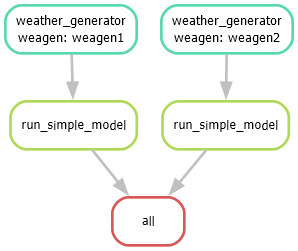

In [11]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config_RR.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

We see that snake understood that we now want to run the weather generator twice. In the *weather_generator* rule we also see in the picture that Snake identified the creation of the **weagen** wildcard and parallelized our workflow for our two wildcard ID: *weagen1* and *weagen2*.

And now let's run the workflow (with the new configfile!):

In [21]:
! snakemake --unlock -s Snakefile_RR --configfile config/snake_config_RR.yml
%runrealcmd snakemake all -s Snakefile_RR -c 1 --configfile config/snake_config_RR.yml

Building DAG of jobs...
Unlocked working directory.


Assuming unrestricted shared filesystem usage.
host: L50060
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                  count
-----------------  -------
all                      1
run_simple_model         2
weather_generator        2
total                    5

Select jobs to execute...
Execute 1 jobs...

[Mon Nov 25 15:06:51 2024]
localrule weather_generator:
    output: data/precip_evapo_weagen2.csv
    jobid: 4
    reason: Missing output files: data/precip_evapo_weagen2.csv
    wildcards: weagen=weagen2
    resources: tmpdir=C:\Users\vertegaa\AppData\Local\Temp

Creating weather data from 2022-09-01 to 2022-12-31
Writing weather data to c:\Code\Snakemake\deltares_snakemake\data\precip_evapo_weagen2.csv
Plotting weather data in c:\Code\Snakemake\deltares_snakemake\data\weather_plot.jpg
[Mon Nov 25 15:06:53 2024]
Finished job 4.
1 of 5 steps (20%) done
Select jobs to execute...
Execute 1

And check that everything ran properly by re-building the workflow image:

Building DAG of jobs...


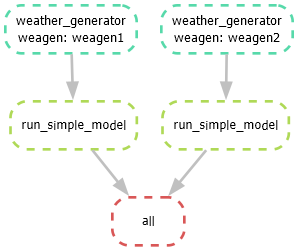

In [22]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config_RR.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

#### Wildcards with different properties ####

In our previous example, our different weathergen run had exactly the same settings. Let's see how we can vary these settings per weagen instance. For this we will need to edit our config to define per instance the parameter value (intead of a list of weagen IDs we start a dictionnary with properties per ID). 

And let's add a third instance as well for fun! This time with different parameters (feel free to change them):

In [23]:
%%writefile ./config/snake_config_RR.yml
# This first line is used to save the snakeconfig below into a file called "config/snake_config_RR.yml"

######################################################################################
####################### Content of the snake config ##################################
# Here general configuration things are stored, which can be used as inputs to workflow rules
# within the snakemake workflow. The layout is standard yaml and will be available in snakemake
# as a dictionary

# a relative path to output
output_dir: output/

## Weather generator parameters ##
# Defining the different weathergen run instances
# and this time the corresponding parameters values with them
weagen_ids:
    weagen1:
        start_date: 2022-09-01
        end_date: 2022-12-31
        evapo: 1.5
        p_01: 0.2
        p_10: 0.3
        rainfall_thres: 1.0
        multiplier: 50
    weagen2:
        start_date: 2022-09-01
        end_date: 2022-12-31
        evapo: 1.5
        # more arid climate
        p_01: 0.1
        p_10: 0.7
        rainfall_thres: 2.0
        multiplier: 50
    weagen3:
        start_date: 2030-09-01
        end_date: 2030-12-31
        evapo: 1.5
        p_01: 0.2
        p_10: 0.3
        rainfall_thres: 1.0
        multiplier: 60

## Hydrology model parameters ##
hydro_parameters:
  # below we define some parameters for a very simple hydrological model, stocks in mm and time scales in days
  interception: 1
  storage_1_max: 100
  alpha: 0.6
  k_fast: 7
  k_slow: 150
  storage_1: 40
  storage_2: 20

Overwriting ./config/snake_config_RR.yml


Well our weagen instances can still be accessed by config["weagen_ids"] but the corresponding parameters and values are now actually a function of the weagen instance. For this snakemake will need us to define **get_** functions of our wildcard to get the corresponding parameter value of each instance. During the rule, the wildcards are passed directly as argument to our get_* functions.

Our updated workflow will look like this:

In [24]:
%%writefile ./Snakefile_RR
# This first line is used to save the snake code below into a file called "Snakefile"

######################################################################################
####################### Content of the Snakefile #####################################
### Import some useful python library ###

### Functions to get parameter values for each weagen wildcard instance ###
def get_start_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["start_date"]

def get_end_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["end_date"]

def get_multiplier(wildcards):
    return config["weagen_ids"][wildcards.weagen]["multiplier"]

def get_evapo(wildcards):
    return config["weagen_ids"][wildcards.weagen]["evapo"]

def get_p_01(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_01"]

def get_p_10(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_10"]

def get_rainfall_thres(wildcards):
    return config["weagen_ids"][wildcards.weagen]["rainfall_thres"]


### Worflow and rules ###
# The master rule defines what eventually will be expected as output, basically it is a rule with only inputs
rule all:
    input:
        expand((config["output_dir"] + "river_flow_{weagen}.csv"), weagen=config["weagen_ids"])
    	

# rule to generate weather timeseries
rule weather_generator:
    # there is not input section because this rule does not require any inputs
    output:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    # parameters can be anything like strings, numbers, etc.
    params:
    	start_date = get_start_date,
    	end_date = get_end_date,
    	multiplier = get_multiplier,
    	evapo = get_evapo,
    	p_01 = get_p_01,
    	p_10 = get_p_10,
    	rainfall_thres = get_rainfall_thres,
    script:
        "scripts/weather_generator.py"

# Rule to run the hydrology model with input from the weather generator
rule run_simple_model:
    input:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    output:
        hydro_csv = config["output_dir"] + "river_flow_{weagen}.csv"
    params:
        hydro_parameters = config["hydro_parameters"]
    script:
        "scripts/simple_hydrology.py"

Overwriting ./Snakefile_RR


Let's have a look at the graph: (our two previous runs were done but not the additional one)

Building DAG of jobs...


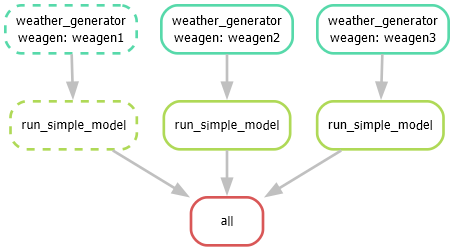

In [25]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config_RR.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

And run the workflow!

In [26]:
! snakemake --unlock -s Snakefile_RR --configfile config/snake_config_RR.yml
%runrealcmd snakemake all -s Snakefile_RR -c 1 --configfile config/snake_config_RR.yml

Building DAG of jobs...
Unlocked working directory.


Assuming unrestricted shared filesystem usage.
host: L50060
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                  count
-----------------  -------
all                      1
run_simple_model         2
weather_generator        2
total                    5

Select jobs to execute...
Execute 1 jobs...

[Mon Nov 25 15:11:04 2024]
localrule weather_generator:
    output: data/precip_evapo_weagen3.csv
    jobid: 6
    reason: Missing output files: data/precip_evapo_weagen3.csv
    wildcards: weagen=weagen3
    resources: tmpdir=C:\Users\vertegaa\AppData\Local\Temp

Creating weather data from 2030-09-01 to 2030-12-31
Writing weather data to c:\Code\Snakemake\deltares_snakemake\data\precip_evapo_weagen3.csv
Plotting weather data in c:\Code\Snakemake\deltares_snakemake\data\weather_plot.jpg
[Mon Nov 25 15:11:05 2024]
Finished job 6.
1 of 5 steps (20%) done
Select jobs to execute...
Execute 1

#### Paramspace ####

With wildcards we can nicely generalize the workflow and even pass some specific options per wildcard instance. But the more specific options or parameter values, the more tedious the workflow is.

**Paramspace** is a snakemake tool that allows to easily replicate our workflow for exploration of different parameter values. In that case the parameter names and values can be defined simply in a **csv file** with the first line listing the parameter names (column title) and each next line of the csv file is a combination of parameter/values.

More info on Paramspace in the [snakemake documentation](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#parameter-space-exploration).

In our example we will use **Paramspace** to change the parameters of the hydrological model. Let's first see what the corresponding csv file would look like and let's add a second line for good measure:

In [27]:
%%writefile ./config/hydro_parameters.csv

interception,storage_1_max,alpha,k_fast,k_slow,storage_1,storage_2
1,100,0.6,7,150,40,20
2,50,0.6,7,150,40,20

Writing ./config/hydro_parameters.csv


And now let's see the impact in our Snakefile:

- we need to import the Paramspace class from snakemake.utils 
- the csv file is read using pandas and use to instantiate our Paramspace
- within the rule we can use several properties of paramspace: instance, wildcard_pattern, instance_patterns

Some example what those properties returns. If we have a csv table with two parameters `a`, `b` and two value combination: \
```
a,b
1,2
3,4 
```

Then during the running of the rule for line 1:
- instance = `{'a': 1, 'b': 2}`
- wildcard_pattern = `'a~1_b~2'`
- instance_patterns = `['a~1_b~2', 'a~3_b~4']`

Note: here our filenames of paramspace are concatenated into one filename (no subfolders), using different separators `'~'`, `'_'` between parameters and their values. These are the defaults but you can change this when initiliasing the Paramspace.

In [28]:
%%writefile ./Snakefile_RR
# This first line is used to save the snake code below into a file called "Snakefile"

######################################################################################
####################### Content of the Snakefile #####################################
### Import some useful python library ###
import pandas as pd
from snakemake.utils import Paramspace

### Create the Paramspace object ###
paramspace = Paramspace(pd.read_csv("config/hydro_parameters.csv", sep=","), filename_params="*", param_sep="~", filename_sep="_")

### Functions to get parameter values for each weagen wildcard instance ###
def get_start_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["start_date"]

def get_end_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["end_date"]

def get_multiplier(wildcards):
    return config["weagen_ids"][wildcards.weagen]["multiplier"]

def get_evapo(wildcards):
    return config["weagen_ids"][wildcards.weagen]["evapo"]

def get_p_01(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_01"]

def get_p_10(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_10"]

def get_rainfall_thres(wildcards):
    return config["weagen_ids"][wildcards.weagen]["rainfall_thres"]

### Worflow and rules ###
# The master rule defines what eventually will be expected as output, basically it is a rule with only inputs
rule all:
    input:
        expand((config["output_dir"] + "river_flow_{weagen}_{params}.csv"), weagen=config["weagen_ids"], params=paramspace.instance_patterns)
    	

# rule to generate weather timeseries
rule weather_generator:
    # there is not input section because this rule does not require any inputs
    output:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    # parameters can be anything like strings, numbers, etc.
    params:
    	start_date = get_start_date,
    	end_date = get_end_date,
    	multiplier = get_multiplier,
    	evapo = get_evapo,
    	p_01 = get_p_01,
    	p_10 = get_p_10,
    	rainfall_thres = get_rainfall_thres,
    script:
        "scripts/weather_generator.py"

# Rule to run the hydrology model with input from the weather generator
rule run_simple_model:
    input:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    output:
        hydro_csv = config["output_dir"] + "river_flow_{weagen}_" + f"{paramspace.wildcard_pattern}.csv"
    params:
        hydro_parameters = paramspace.instance,
    script:
        "scripts/simple_hydrology.py"

Overwriting ./Snakefile_RR


Let's have a look at the graph where you should now see automatically two hydrological model runs per weagen run. You also see per hydrological run the values of each of the parameter in Paramspace automatically passed:

Building DAG of jobs...


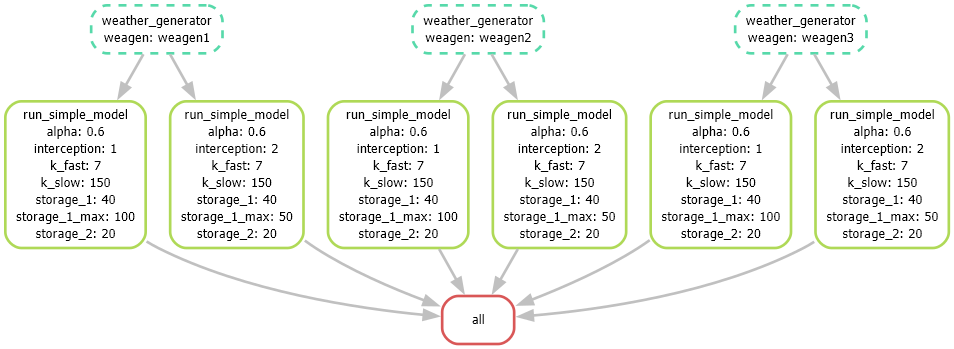

In [29]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config_RR.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

And finally let's run the workflow:

In [30]:
! snakemake --unlock -s Snakefile_RR --configfile config/snake_config_RR.yml
%runrealcmd snakemake all -s Snakefile_RR -c 1 --configfile config/snake_config_RR.yml

Building DAG of jobs...
Unlocked working directory.


Assuming unrestricted shared filesystem usage.
host: L50060
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                 count
----------------  -------
all                     1
run_simple_model        6
total                   7

Select jobs to execute...
Execute 1 jobs...

[Mon Nov 25 17:17:05 2024]
localrule run_simple_model:
    input: data/precip_evapo_weagen3.csv
    output: output/river_flow_weagen3_interception~2_storage_1_max~50_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
    jobid: 9
    reason: Missing output files: output/river_flow_weagen3_interception~2_storage_1_max~50_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
    wildcards: weagen=weagen3, interception=2, storage_1_max=50, alpha=0.6, k_fast=7, k_slow=150, storage_1=40, storage_2=20
    resources: tmpdir=C:\Users\vertegaa\AppData\Local\Temp

{'interception': np.int64(2), 'storage_1_max': np.

Let's have a look at all the files we've created so far in the data and output folder:

In [31]:
roots = ["data", "output"]
for root in roots:
    for path, _, files in os.walk(root):
        print(path)
        for name in files:
            if name.endswith(".gitkeep"):
                continue
            print(f" - {name}")

data
 - hello_world.txt
 - precip_evapo.csv
 - precip_evapo_weagen1.csv
 - precip_evapo_weagen2.csv
 - precip_evapo_weagen3.csv
 - snake.txt
output
 - hello_world.txt
 - plot_results_example.png
 - river_flow.csv
 - river_flow_weagen1.csv
 - river_flow_weagen1_interception~1_storage_1_max~100_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - river_flow_weagen1_interception~2_storage_1_max~50_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - river_flow_weagen2.csv
 - river_flow_weagen2_interception~1_storage_1_max~100_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - river_flow_weagen2_interception~2_storage_1_max~50_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - river_flow_weagen3.csv
 - river_flow_weagen3_interception~1_storage_1_max~100_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - river_flow_weagen3_interception~2_storage_1_max~50_alpha~0.6_k_fast~7_k_slow~150_storage_1~40_storage_2~20.csv
 - snake2.txt


### Adding a rule for plotting: your turn! ###

The exercise is now finished but if you would like you can try and add a new custom rule to plot the results of the weather generator / hydrological model. We started a small python script for it that you can adjust for your workflow : **script/plot_timeseries.py**

Here is an example of plots you could get:

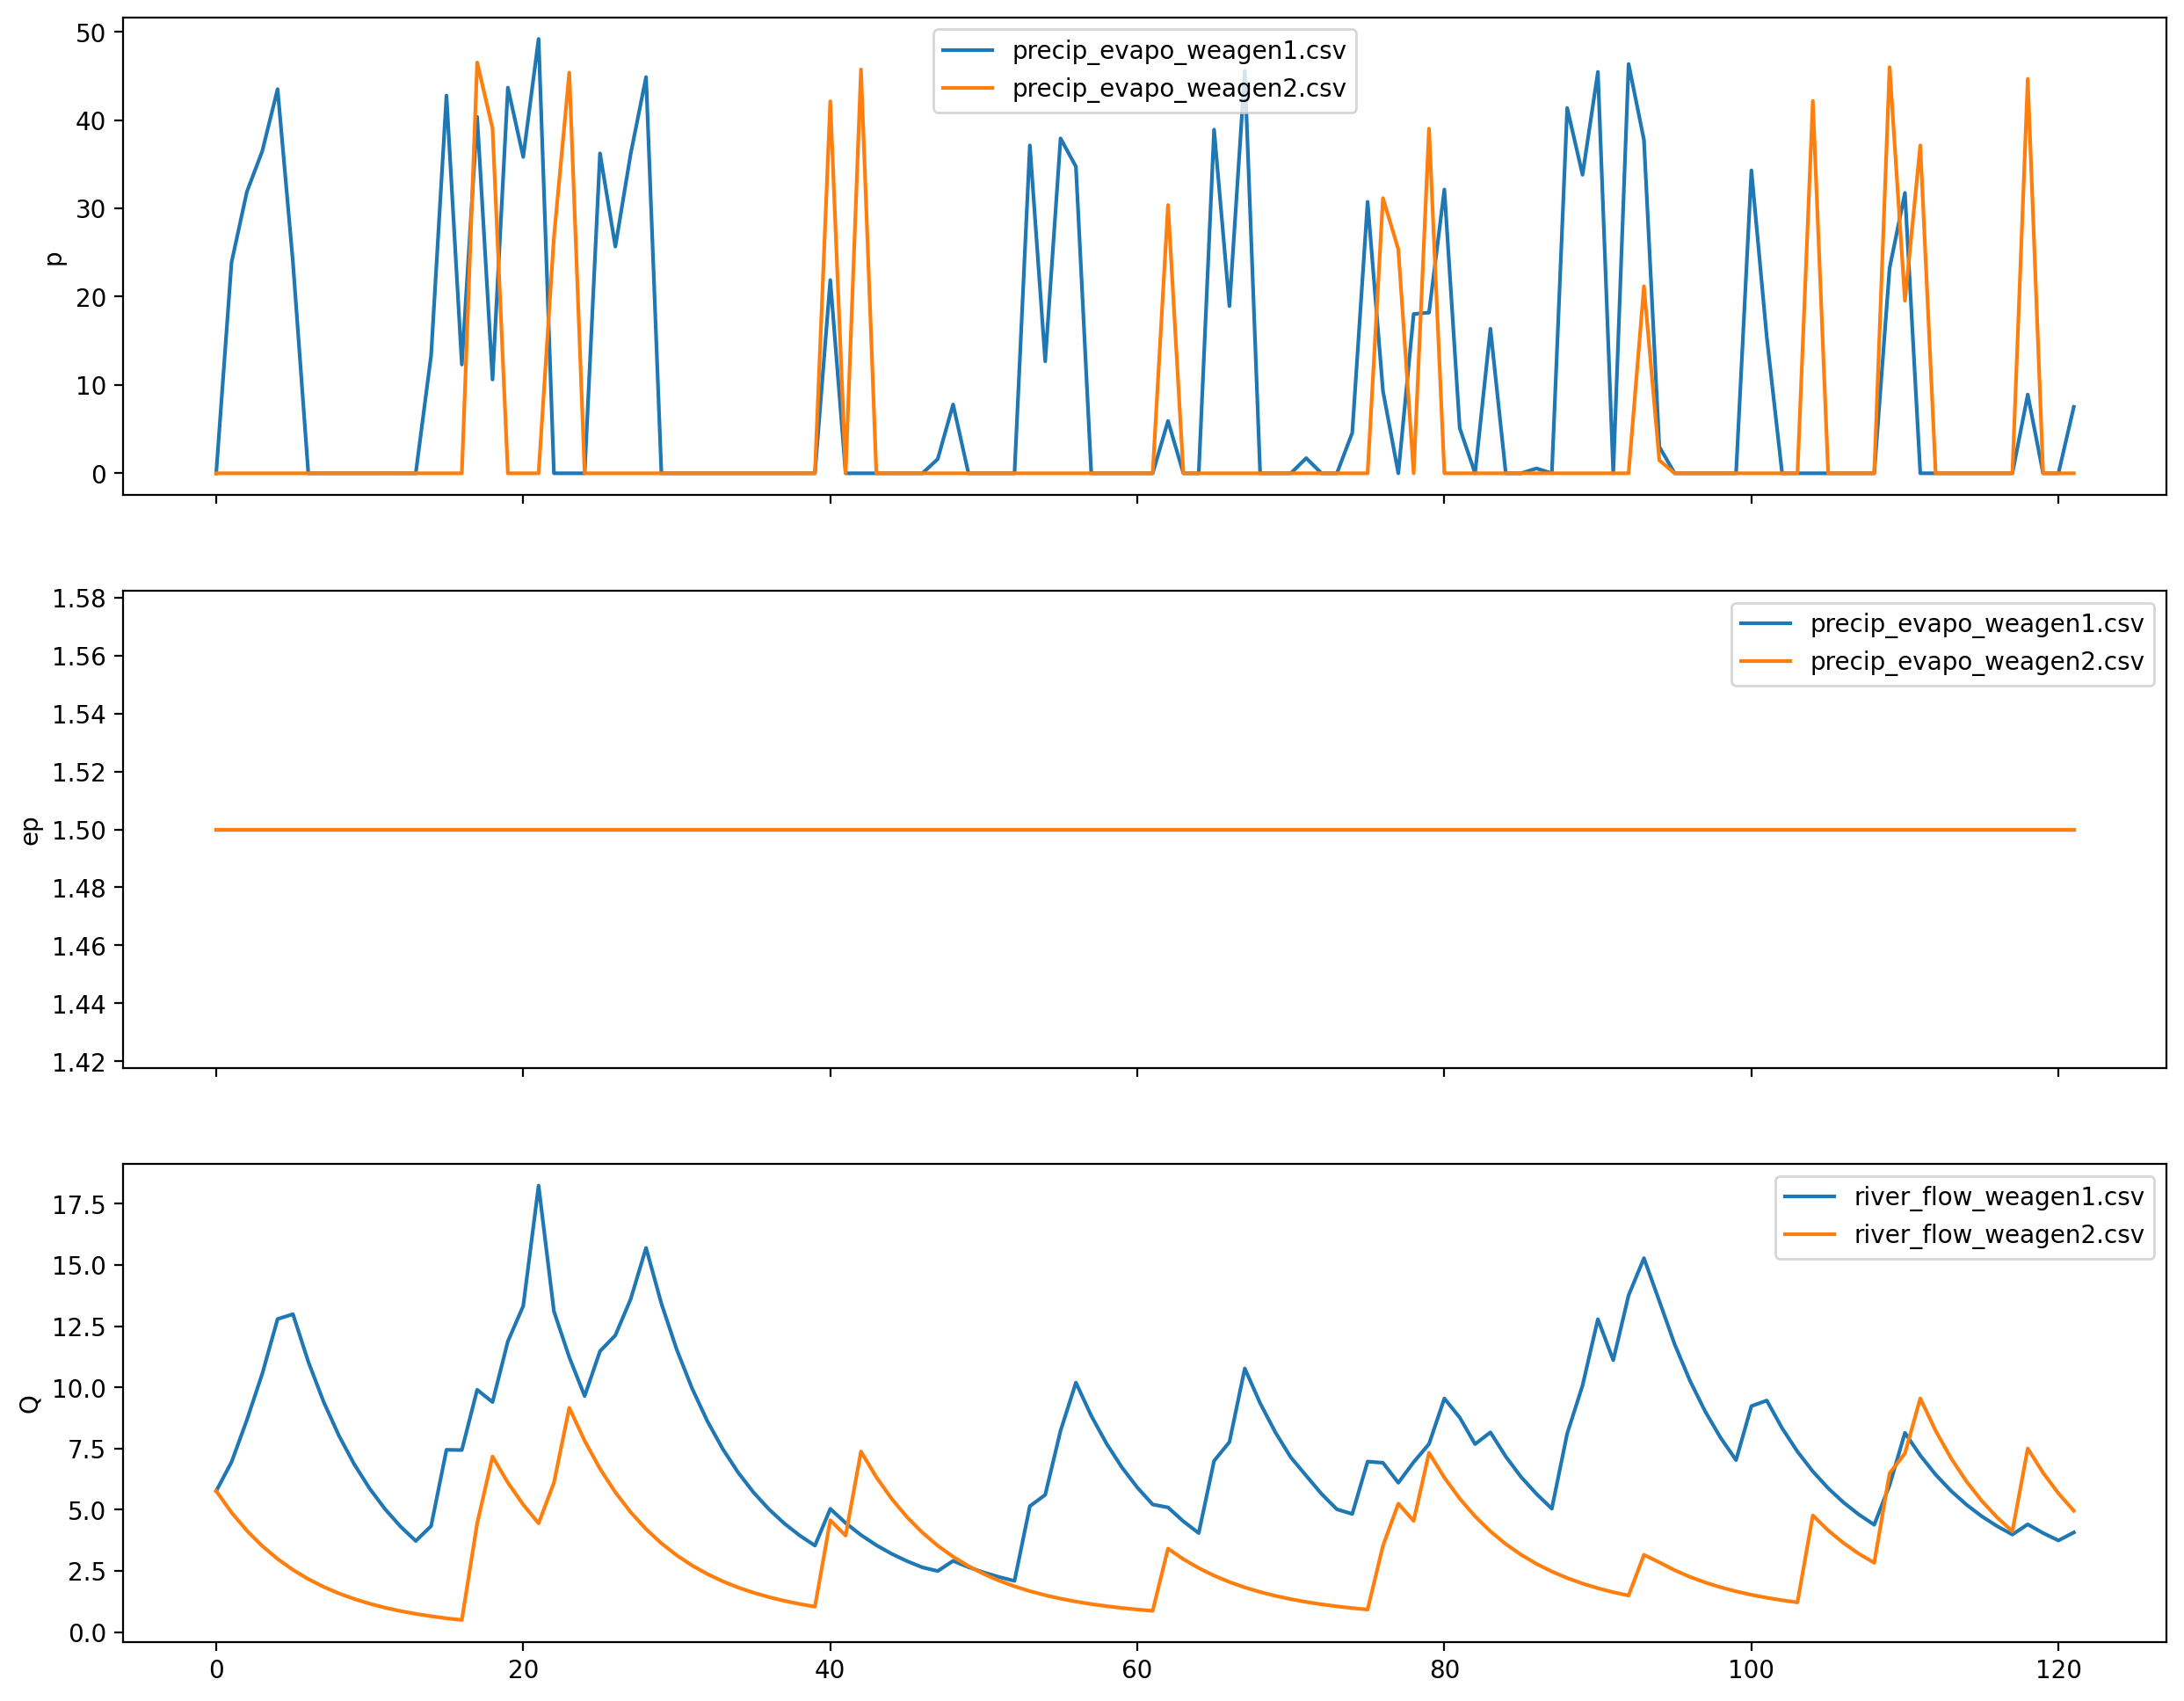

In [32]:
display.Image("./output/plot_results_example.png")

And below are the code line containing the previous version of our Snakefile, the plotting script and the lines to run it if you'd like to stay in this notebook to add your rule (else you can adjust the Snakefile itself and run from a classic command line):

In [33]:
%%writefile ./Snakefile_RR
# This first line is used to save the snake code below into a file called "Snakefile"

######################################################################################
####################### Content of the Snakefile #####################################
### Import some useful python library ###
import pandas as pd
from snakemake.utils import Paramspace

### Create the Paramspace object ###
paramspace = Paramspace(pd.read_csv("config/hydro_parameters.csv", sep=","), filename_params="*", param_sep="~", filename_sep="_")

### Functions to get parameter values for each weagen wildcard instance ###
def get_start_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["start_date"]

def get_end_date(wildcards):
    return config["weagen_ids"][wildcards.weagen]["end_date"]

def get_multiplier(wildcards):
    return config["weagen_ids"][wildcards.weagen]["multiplier"]

def get_evapo(wildcards):
    return config["weagen_ids"][wildcards.weagen]["evapo"]

def get_p_01(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_01"]

def get_p_10(wildcards):
    return config["weagen_ids"][wildcards.weagen]["p_10"]

def get_rainfall_thres(wildcards):
    return config["weagen_ids"][wildcards.weagen]["rainfall_thres"]

### Worflow and rules ###
# The master rule defines what eventually will be expected as output, basically it is a rule with only inputs
rule all:
    input:
        expand((config["output_dir"] + "river_flow_{weagen}_{params}.csv"), weagen=config["weagen_ids"], params=paramspace.instance_patterns)
    	

# rule to generate weather timeseries
rule weather_generator:
    # there is not input section because this rule does not require any inputs
    output:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    # parameters can be anything like strings, numbers, etc.
    params:
    	start_date = get_start_date,
    	end_date = get_end_date,
    	multiplier = get_multiplier,
    	evapo = get_evapo,
    	p_01 = get_p_01,
    	p_10 = get_p_10,
    	rainfall_thres = get_rainfall_thres,
    script:
        "scripts/weather_generator.py"

# Rule to run the hydrology model with input from the weather generator
rule run_simple_model:
    input:
        weather_csv = "data/precip_evapo_{weagen}.csv"
    output:
        hydro_csv = config["output_dir"] + "river_flow_{weagen}_" + f"{paramspace.wildcard_pattern}.csv"
    params:
        hydro_parameters = paramspace.instance,
    script:
        "scripts/simple_hydrology.py"

Overwriting ./Snakefile_RR


In [34]:
%%writefile ./scripts/plot_timeseries.py
# This first line is used to save the python code below into a file called "scripts/plot_timeseries.py"

######################################################################################
####################### Content of the python script #################################
import os
import pandas as pd
import matplotlib.pyplot as plt

# Main function 
def plot_timeseries(csv_files: list, variables: list, outputfile: str, **kwargs) -> None:
    """
    Reads different csv files in csv_files list and prepares a plot per variable in variables list.
    The plot will be saved to outputfile.
    
    kwargs can be used to pass specific arguments into the pandas.read_csv function.
    """
    # Initialiase plots
    print(f"Initialising plots for variables {variables} based on csv files: {csv_files}")
    n = len(variables)
    fig, axes = plt.subplots(n, 1, sharex=True, figsize=(15, n * 4))
    axes = [axes] if n == 1 else axes

    # Loop over csv files
    for fn in csv_files:
        # Read file
        print(f"Reading csv file {fn}")
        df = pd.read_csv(fn, **kwargs)

        # Loop over varibales to add to plot if they are present in the csv file
        for i in range(len(variables)):
            var = variables[i]
            if var in df.columns:
                df[var].plot.line(
                    ax=axes[i],
                    x="time",
                    label=os.path.basename(fn),
                )
    # Set axis label/legend
    for i in range(len(variables)):
        axes[i].set_ylabel(variables[i])
        axes[i].legend()
    
    # Save plot
    print(f"Saving plot in {outputfile}")
    fig.savefig(outputfile, bbox_inches="tight", dpi=200)
    

# Get the snakemake arguments
csv_files = ['data/precip_evapo_weagen1.csv', 'output/river_flow_weagen1.csv', 'data/precip_evapo_weagen2.csv', 'output/river_flow_weagen2.csv']
variables = ['p', 'ep', 'Q']
outputfile = 'output/plot_results_example.png'

# Run our function
plot_timeseries(
    csv_files = csv_files, 
    variables = variables, 
    outputfile = outputfile,
)

Overwriting ./scripts/plot_timeseries.py


Building DAG of jobs...


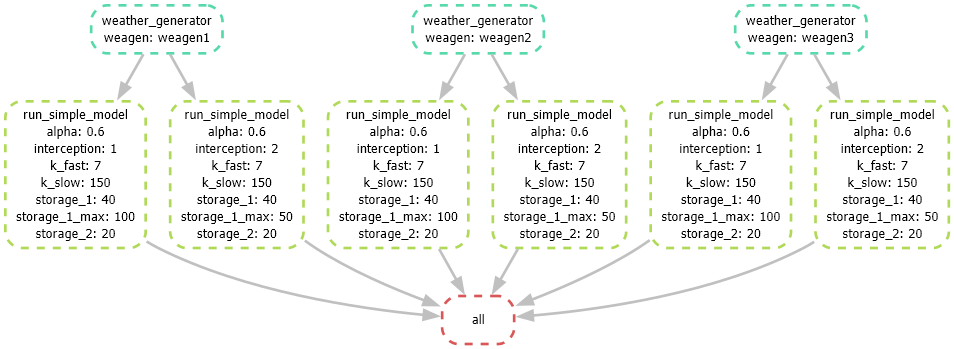

In [35]:
# Snake Command line to build the image
! snakemake -s Snakefile_RR --configfile config/snake_config_RR.yml --dag | dot -Tpng > _images/dag_RR.png
# Python command to visualise the built image in our notebook
display.Image("./_images/dag_RR.png")

In [36]:
! snakemake --unlock -s Snakefile_RR --configfile config/snake_config_RR.yml
%runrealcmd snakemake all -s Snakefile_RR -c 1 --configfile config/snake_config_RR.yml

Building DAG of jobs...
Unlocked working directory.


Assuming unrestricted shared filesystem usage.
host: L50060
Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
